Loading and cleaning data...
Raw dataset: 50694 rows and 29 columns
Created date column from year, month, and day columns
Converted spend_all to numeric
Converted spend_aap to numeric
Converted spend_acf to numeric
Converted spend_aer to numeric
Converted spend_apg to numeric
Converted spend_durables to numeric
Converted spend_nondurables to numeric
Converted spend_grf to numeric
Converted spend_gen to numeric
Converted spend_hic to numeric
Converted spend_hcs to numeric
Converted spend_inperson to numeric
Converted spend_inpersonmisc to numeric
Converted spend_remoteservices to numeric
Converted spend_sgh to numeric
Converted spend_tws to numeric
Converted spend_retail_w_grocery to numeric
Converted spend_retail_no_grocery to numeric
Converted spend_all_incmiddle to numeric
Converted spend_all_q1 to numeric
Converted spend_all_q2 to numeric
Converted spend_all_q3 to numeric
Converted spend_all_q4 to numeric
Filled 1644 missing values in spend_all
Filled 1644 missing values in spend_aa

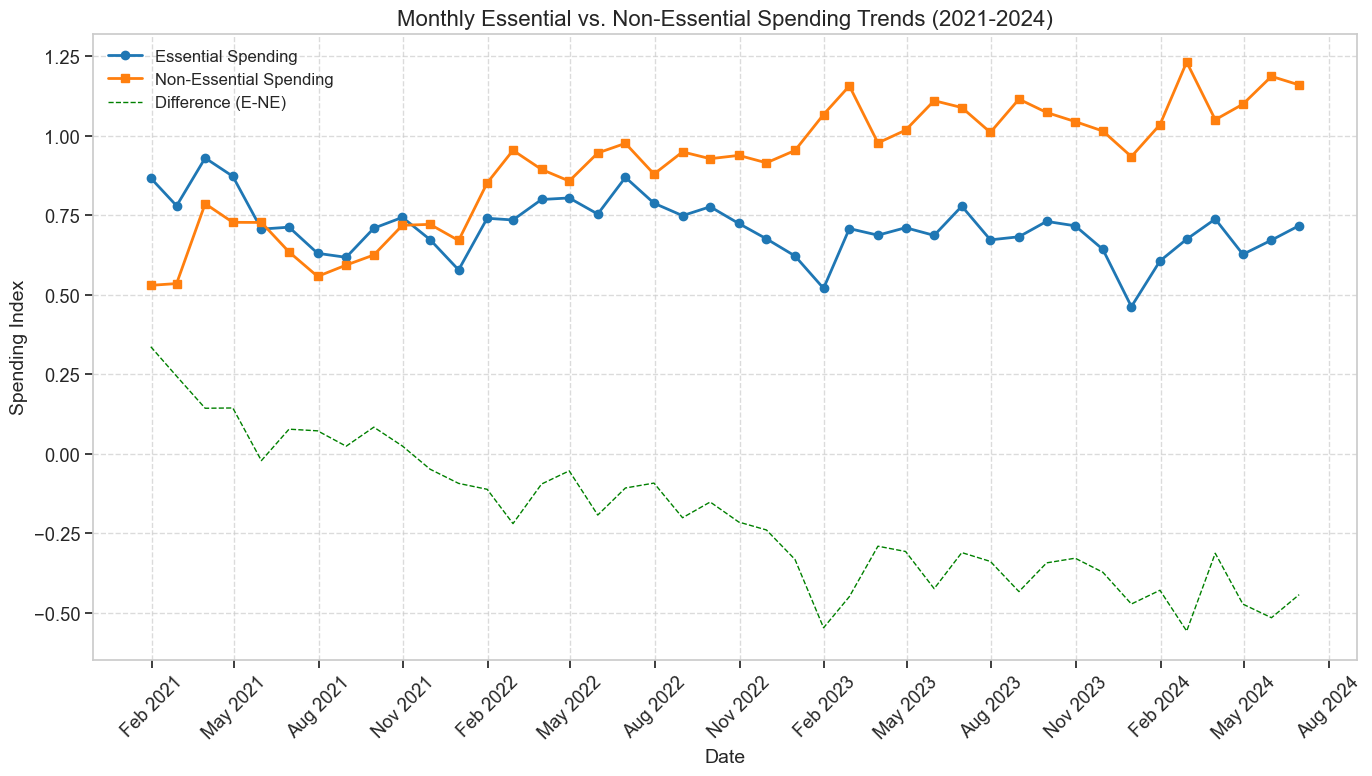

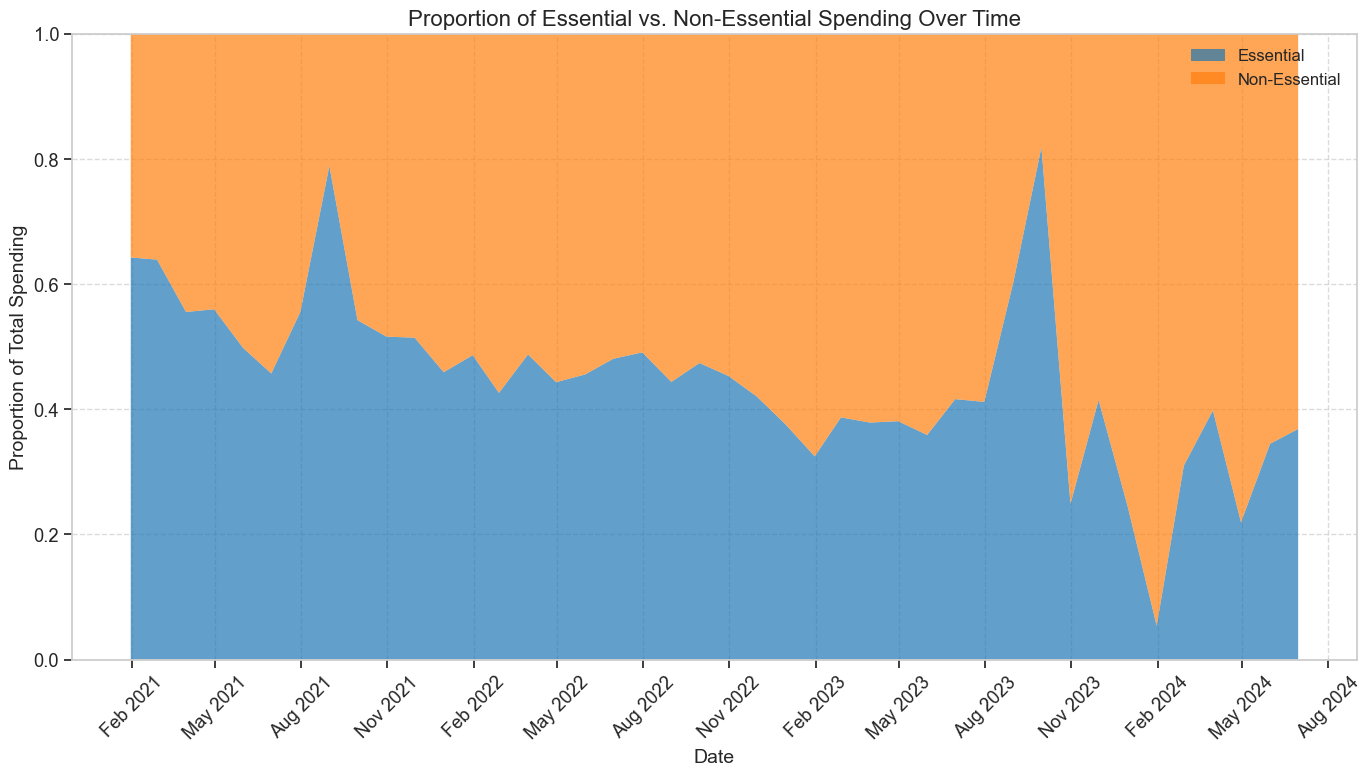

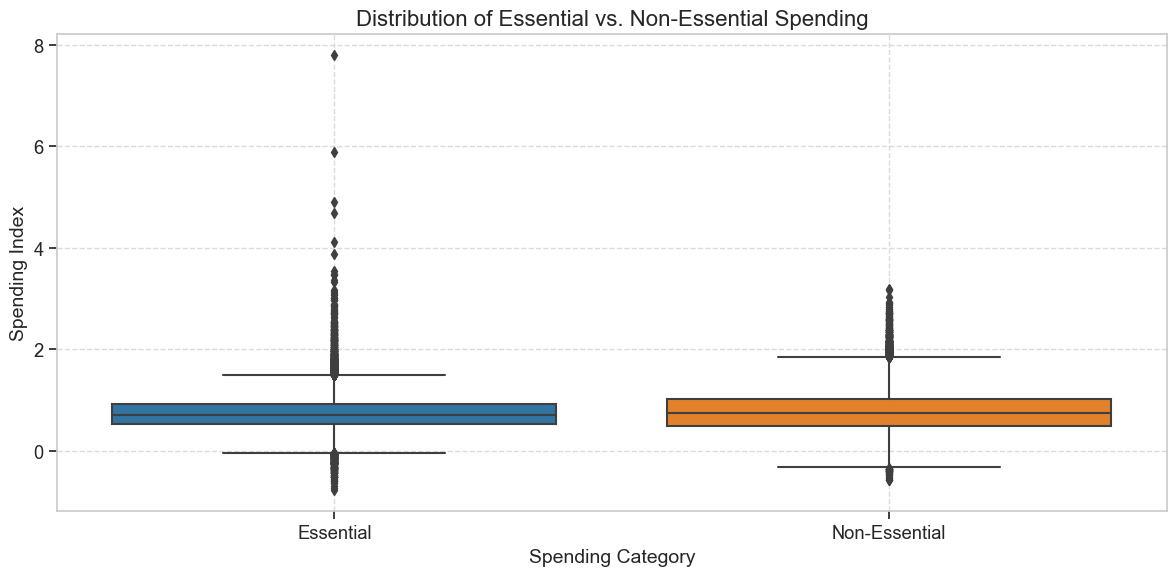

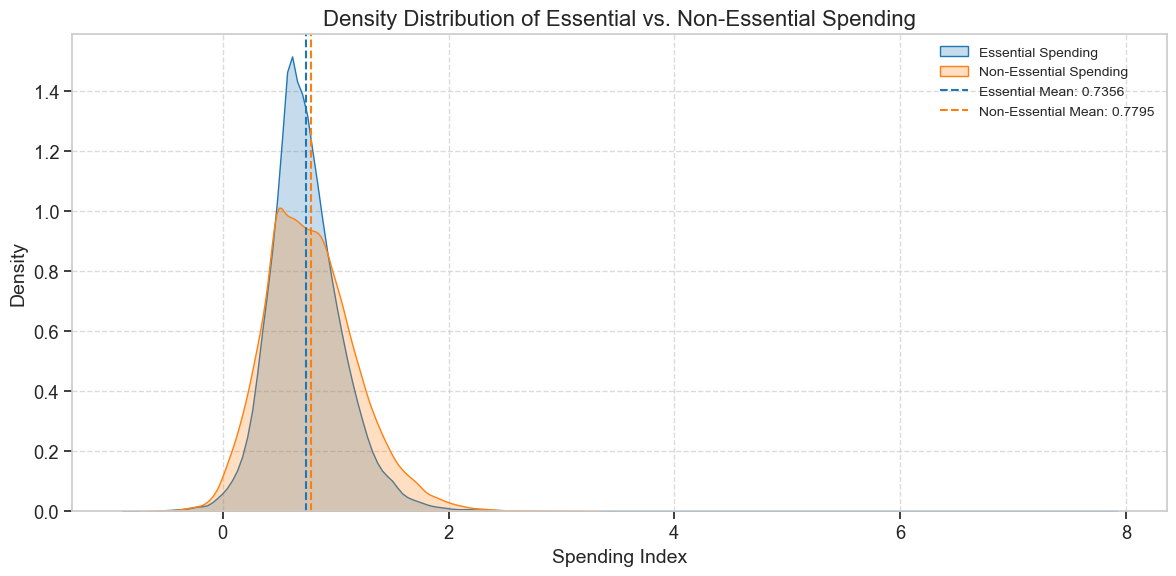

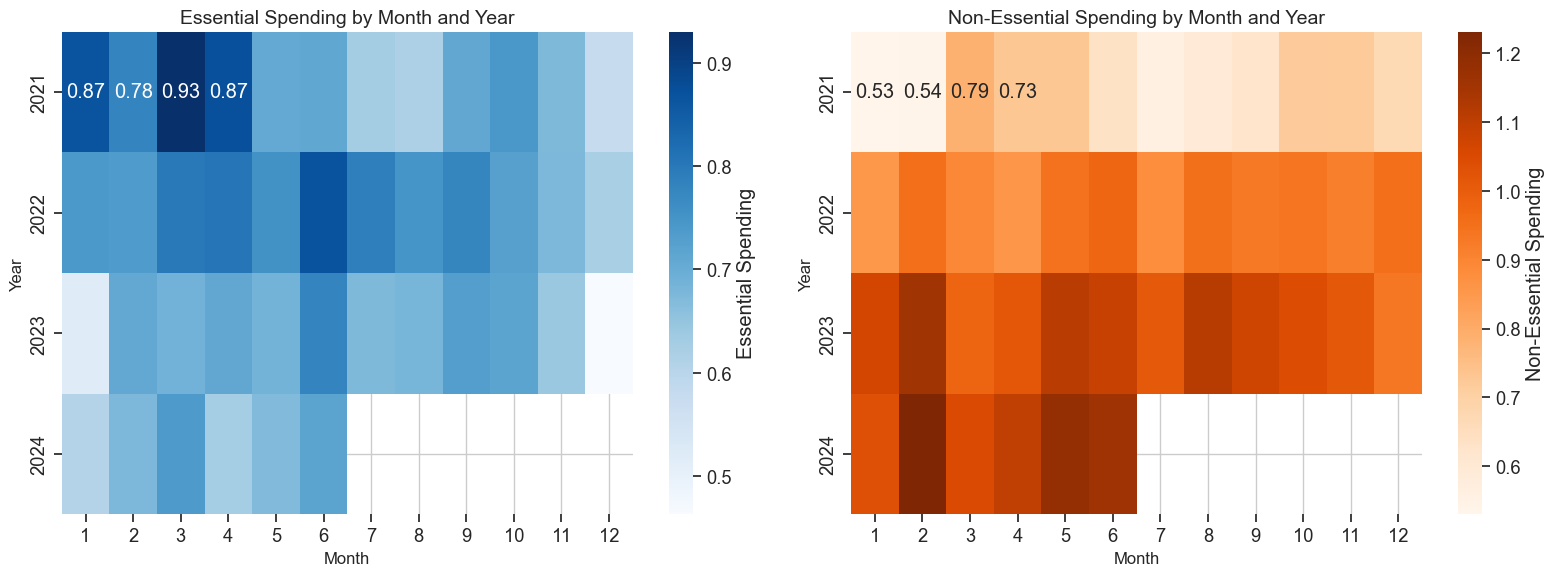


Performing statistical analysis...

Paired t-test results:
t-statistic = -18.4365, p-value = 0.0000000000
Effect size (Cohen's d): -0.1165 (negligible)

Wilcoxon signed-rank test:
statistic = 234957998.5000, p-value = 0.0000000000

Coefficient of Variation (lower = more stable):
Essential spending: 0.4626
Non-essential spending: 0.5271
Relative stability ratio (Essential/Non-Essential): 0.8776

Correlation between essential and non-essential spending: 0.3681

Comparative Summary Statistics:
                     Metric Essential Non-Essential
0       Mean Spending Index    0.7356        0.7795
1     Median Spending Index    0.7007        0.7430
2        Standard Deviation    0.3403        0.4109
3  Coefficient of Variation    0.4626        0.5271
4       Proportion of Total    50.69%        49.31%
5                 Min Value   -0.7640       -0.5775
6                 Max Value    7.7935        3.1880
7                     Range    8.5575        3.7655

Academic Summary Paragraph:

Durin

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

# Set the aesthetic parameters for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# --------- DATA LOADING AND CLEANING ---------
print("Loading and cleaning data...")

# Load the dataset
file_path = "D:/capstone/datasets/Affinity - State - Daily.xlsx"
df = pd.read_excel(file_path)
print(f"Raw dataset: {df.shape[0]} rows and {df.shape[1]} columns")

# Create date column if it doesn't exist
if 'date' not in df.columns:
    if all(col in df.columns for col in ['year', 'month', 'day']):
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        print("Created date column from year, month, and day columns")

# Define essential and non-essential spending categories
essential_columns = ['spend_retail_w_grocery', 'spend_sgh', 'spend_grf']
non_essential_columns = ['spend_durables', 'spend_inpersonmisc', 'spend_remoteservices', 'spend_apg']

# Convert string values to numeric
for col in df.columns:
    if col.startswith('spend_') and df[col].dtype == 'object':
        df[col] = df[col].replace('.', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric")

# Handle missing values in spending columns
for col in df.columns:
    if col.startswith('spend_') and df[col].isna().sum() > 0:
        missing_count = df[col].isna().sum()
        df[col] = df[col].fillna(df[col].median())
        print(f"Filled {missing_count} missing values in {col}")

# Filter for recovery phase (2021 onwards)
df_recovery = df[df['date'] >= '2021-01-01'].copy()
print(f"Recovery phase data: {len(df_recovery)} rows from {df_recovery['date'].min().strftime('%Y-%m-%d')} to {df_recovery['date'].max().strftime('%Y-%m-%d')}")

# Check if all required columns exist
available_essential = [col for col in essential_columns if col in df_recovery.columns]
available_non_essential = [col for col in non_essential_columns if col in df_recovery.columns]
print(f"Available essential categories: {available_essential}")
print(f"Available non-essential categories: {available_non_essential}")

# Create aggregate essential and non-essential spending
if available_essential:
    df_recovery['essential_spending'] = df_recovery[available_essential].sum(axis=1)
else:
    print("Warning: No essential spending columns available")
    df_recovery['essential_spending'] = 0

if available_non_essential:
    df_recovery['non_essential_spending'] = df_recovery[available_non_essential].sum(axis=1)
else:
    print("Warning: No non-essential spending columns available")
    df_recovery['non_essential_spending'] = 0

# Calculate proportions
total_spending = df_recovery['essential_spending'] + df_recovery['non_essential_spending']
df_recovery['essential_proportion'] = df_recovery['essential_spending'] / total_spending
df_recovery['non_essential_proportion'] = df_recovery['non_essential_spending'] / total_spending

# --------- EXPLORATORY DATA ANALYSIS ---------
print("\nPerforming exploratory data analysis...")

# Summary statistics
essential_stats = df_recovery['essential_spending'].describe()
non_essential_stats = df_recovery['non_essential_spending'].describe()

stats_comparison = pd.DataFrame({
    'Essential Spending': essential_stats,
    'Non-Essential Spending': non_essential_stats,
    'Difference': essential_stats - non_essential_stats
})
print("\nSummary Statistics:")
print(stats_comparison.round(4))

# Group by month for time series analysis
monthly_data = df_recovery.groupby(pd.Grouper(key='date', freq='M')).agg({
    'essential_spending': 'mean',
    'non_essential_spending': 'mean',
    'essential_proportion': 'mean',
    'non_essential_proportion': 'mean'
}).reset_index()

# --------- VISUALIZATIONS ---------
print("\nCreating visualizations...")

# 1. Time series trend
plt.figure(figsize=(14, 8))
plt.plot(monthly_data['date'], monthly_data['essential_spending'], 
         marker='o', linewidth=2, label='Essential Spending', color='#1f77b4')
plt.plot(monthly_data['date'], monthly_data['non_essential_spending'], 
         marker='s', linewidth=2, label='Non-Essential Spending', color='#ff7f0e')

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Add difference line
monthly_data['difference'] = monthly_data['essential_spending'] - monthly_data['non_essential_spending']
plt.plot(monthly_data['date'], monthly_data['difference'], 
         linestyle='--', linewidth=1, label='Difference (E-NE)', color='green')

plt.title('Monthly Essential vs. Non-Essential Spending Trends (2021-2024)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Spending Index', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('essential_vs_nonessential_trend.png', dpi=300)
plt.show()

# 2. Stacked area chart of proportions
plt.figure(figsize=(14, 8))
plt.stackplot(monthly_data['date'], 
              monthly_data['essential_proportion'], 
              monthly_data['non_essential_proportion'],
              labels=['Essential', 'Non-Essential'],
              colors=['#1f77b4', '#ff7f0e'],
              alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.title('Proportion of Essential vs. Non-Essential Spending Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Proportion of Total Spending', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('spending_proportion.png', dpi=300)
plt.show()

# 3. Box plots
plt.figure(figsize=(12, 6))
plot_data = pd.melt(df_recovery[['essential_spending', 'non_essential_spending']], 
                   var_name='Category', value_name='Spending Index')
plot_data['Category'] = plot_data['Category'].map({
    'essential_spending': 'Essential', 
    'non_essential_spending': 'Non-Essential'
})

sns.boxplot(x='Category', y='Spending Index', data=plot_data, palette=['#1f77b4', '#ff7f0e'])
plt.title('Distribution of Essential vs. Non-Essential Spending', fontsize=16)
plt.xlabel('Spending Category', fontsize=14)
plt.ylabel('Spending Index', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('spending_boxplot.png', dpi=300)
plt.show()

# 4. Density plots
plt.figure(figsize=(12, 6))
sns.kdeplot(df_recovery['essential_spending'], label='Essential Spending', shade=True, color='#1f77b4')
sns.kdeplot(df_recovery['non_essential_spending'], label='Non-Essential Spending', shade=True, color='#ff7f0e')

# Add vertical lines for means
plt.axvline(df_recovery['essential_spending'].mean(), color='#1f77b4', linestyle='--', 
           label=f'Essential Mean: {df_recovery["essential_spending"].mean():.4f}')
plt.axvline(df_recovery['non_essential_spending'].mean(), color='#ff7f0e', linestyle='--', 
           label=f'Non-Essential Mean: {df_recovery["non_essential_spending"].mean():.4f}')

plt.title('Density Distribution of Essential vs. Non-Essential Spending', fontsize=16)
plt.xlabel('Spending Index', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('spending_kde.png', dpi=300)
plt.show()

# 5. Seasonal patterns by month and year
df_recovery['year'] = df_recovery['date'].dt.year
df_recovery['month'] = df_recovery['date'].dt.month

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
monthly_essential = df_recovery.groupby(['year', 'month'])['essential_spending'].mean().unstack()
sns.heatmap(monthly_essential, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Essential Spending'})
plt.title('Essential Spending by Month and Year', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.subplot(1, 2, 2)
monthly_nonessential = df_recovery.groupby(['year', 'month'])['non_essential_spending'].mean().unstack()
sns.heatmap(monthly_nonessential, annot=True, fmt=".2f", cmap="Oranges", cbar_kws={'label': 'Non-Essential Spending'})
plt.title('Non-Essential Spending by Month and Year', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.tight_layout()
plt.savefig('seasonal_patterns.png', dpi=300)
plt.show()

# --------- STATISTICAL ANALYSIS ---------
print("\nPerforming statistical analysis...")

# 1. Paired t-test
t_stat, p_value = stats.ttest_rel(df_recovery['essential_spending'], 
                                 df_recovery['non_essential_spending'])
print(f"\nPaired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.10f}")

# 2. Effect size (Cohen's d)
mean_diff = df_recovery['essential_spending'].mean() - df_recovery['non_essential_spending'].mean()
pooled_std = np.sqrt((df_recovery['essential_spending'].std()**2 + 
                      df_recovery['non_essential_spending'].std()**2) / 2)
cohens_d = mean_diff / pooled_std

# Interpret Cohen's d
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"

print(f"Effect size (Cohen's d): {cohens_d:.4f} ({effect_interpretation})")

# 3. Wilcoxon signed-rank test (non-parametric)
try:
    w_stat, w_p_value = stats.wilcoxon(df_recovery['essential_spending'], 
                                      df_recovery['non_essential_spending'])
    print(f"\nWilcoxon signed-rank test:")
    print(f"statistic = {w_stat:.4f}, p-value = {w_p_value:.10f}")
except Exception as e:
    print(f"\nWilcoxon test error: {e}")

# 4. Stability analysis (coefficient of variation)
cv_essential = df_recovery['essential_spending'].std() / df_recovery['essential_spending'].mean()
cv_nonessential = df_recovery['non_essential_spending'].std() / df_recovery['non_essential_spending'].mean()
print(f"\nCoefficient of Variation (lower = more stable):")
print(f"Essential spending: {cv_essential:.4f}")
print(f"Non-essential spending: {cv_nonessential:.4f}")
print(f"Relative stability ratio (Essential/Non-Essential): {cv_essential/cv_nonessential:.4f}")

# 5. Correlation analysis
correlation = df_recovery['essential_spending'].corr(df_recovery['non_essential_spending'])
print(f"\nCorrelation between essential and non-essential spending: {correlation:.4f}")

# --------- SUMMARY ---------
# Final summary statistics table
summary_stats = pd.DataFrame({
    'Metric': [
        'Mean Spending Index', 
        'Median Spending Index',
        'Standard Deviation', 
        'Coefficient of Variation',
        'Proportion of Total',
        'Min Value',
        'Max Value',
        'Range'
    ],
    'Essential': [
        f"{df_recovery['essential_spending'].mean():.4f}",
        f"{df_recovery['essential_spending'].median():.4f}",
        f"{df_recovery['essential_spending'].std():.4f}",
        f"{cv_essential:.4f}",
        f"{df_recovery['essential_proportion'].mean()*100:.2f}%",
        f"{df_recovery['essential_spending'].min():.4f}",
        f"{df_recovery['essential_spending'].max():.4f}",
        f"{df_recovery['essential_spending'].max() - df_recovery['essential_spending'].min():.4f}"
    ],
    'Non-Essential': [
        f"{df_recovery['non_essential_spending'].mean():.4f}",
        f"{df_recovery['non_essential_spending'].median():.4f}",
        f"{df_recovery['non_essential_spending'].std():.4f}",
        f"{cv_nonessential:.4f}",
        f"{df_recovery['non_essential_proportion'].mean()*100:.2f}%",
        f"{df_recovery['non_essential_spending'].min():.4f}",
        f"{df_recovery['non_essential_spending'].max():.4f}",
        f"{df_recovery['non_essential_spending'].max() - df_recovery['non_essential_spending'].min():.4f}"
    ]
})

print("\nComparative Summary Statistics:")
print(summary_stats)

# Generate academic summary paragraph
higher_category = "essential" if df_recovery['essential_spending'].mean() > df_recovery['non_essential_spending'].mean() else "non-essential"
more_stable_category = "essential" if cv_essential < cv_nonessential else "non-essential"
significance_statement = "statistically significant" if p_value < 0.05 else "not statistically significant"

# Format p-value text separately to avoid the f-string nested formatting issue
if p_value < 0.001:
    p_value_text = "p < 0.001"
else:
    p_value_text = f"p = {p_value:.4f}"

academic_summary = f"""
During the recovery phase (2021-2024), {higher_category} spending was consistently higher than {"non-essential" if higher_category == "essential" else "essential"} spending, with mean indices of {df_recovery['essential_spending'].mean():.4f} and {df_recovery['non_essential_spending'].mean():.4f} respectively. The difference between these categories was {significance_statement} (paired t-test: t={t_stat:.3f}, {p_value_text}) with a {effect_interpretation} effect size (Cohen's d = {cohens_d:.3f}). {more_stable_category.capitalize()} spending exhibited greater stability over time, as indicated by a lower coefficient of variation ({cv_essential:.3f} vs. {cv_nonessential:.3f}). Essential spending constituted approximately {df_recovery['essential_proportion'].mean()*100:.1f}% of total analyzed spending. The correlation between the two spending categories was {correlation:.2f}, suggesting {"strong" if correlation > 0.7 else "moderate" if correlation > 0.4 else "weak"} co-movement in spending patterns. This pattern of consumer behavior during the post-pandemic recovery period indicates that {"basic needs maintained priority in household budgets" if higher_category == "essential" else "discretionary purchases gained significant share of wallet, reflecting increasing consumer confidence and economic recovery"}.
"""

print("\nAcademic Summary Paragraph:")
print(academic_summary)

# Save the summary to a text file
with open('essential_vs_nonessential_summary.txt', 'w') as f:
    f.write("ESSENTIAL VS. NON-ESSENTIAL SPENDING ANALYSIS (2021-2024)\n")
    f.write("=" * 60 + "\n\n")
    f.write("STATISTICAL RESULTS\n")
    f.write("-" * 20 + "\n")
    f.write(f"Paired t-test: t={t_stat:.4f}, p={p_value:.10f}\n")
    f.write(f"Effect size (Cohen's d): {cohens_d:.4f} ({effect_interpretation})\n")
    f.write(f"Correlation: {correlation:.4f}\n\n")
    f.write("SUMMARY STATISTICS\n")
    f.write("-" * 20 + "\n")
    f.write(summary_stats.to_string() + "\n\n")
    f.write("ACADEMIC SUMMARY\n")
    f.write("-" * 20 + "\n")
    f.write(academic_summary)

print("\nAnalysis complete. Results saved to 'essential_vs_nonessential_summary.txt'")